# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
# PATH = "./data/"

In [4]:
data = pd.read_csv('train.csv').set_index('PassengerId')

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

Text(0.5, 1.0, 'Amount number of survived or not')

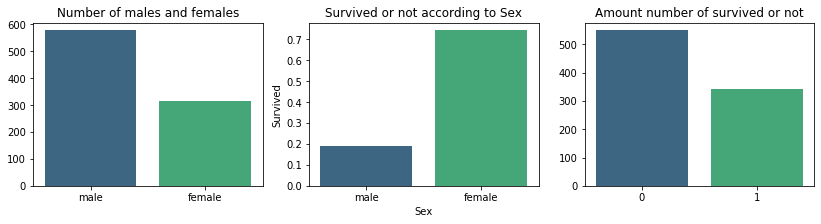

In [5]:
fig, axes = plt.subplots(1,3, figsize=(14,3))
# fig.suptitle('First exercise', fontsize=12)

sns.barplot(ax=axes[0], x=data['Sex'].unique(), y=data['Sex'].value_counts().values, palette="viridis")
axes[0].set_title('Number of males and females')

sns.barplot(ax=axes[1], x=data['Sex'], y=data['Survived'], ci=False, palette="viridis")
axes[1].set_title('Survived or not according to Sex')

sns.barplot(ax=axes[2], x=data['Survived'].unique(), y=data['Survived'].value_counts().values, palette="viridis")
axes[2].set_title('Amount number of survived or not')

##### Thoughts
As we can see above on the grahps, there is a strong correlation between gender and survival. More then 70% of women were survived, while less then 20% of men were survived

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

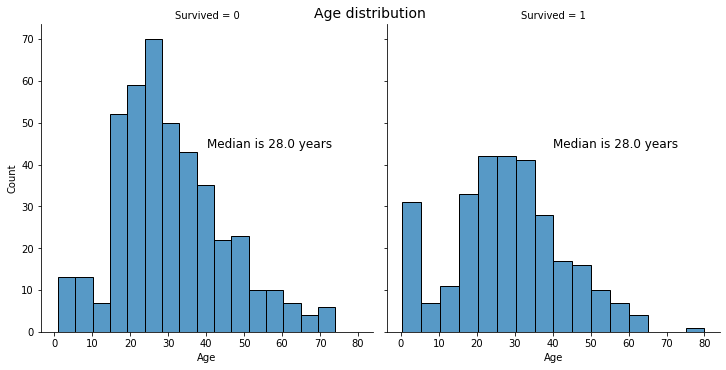

In [6]:
def annotate(data, **kws):
    n = data['Age'].median()
    ax = plt.gca()
    ax.text(.5, .6, f"Median is {n} years" , transform=ax.transAxes, fontsize=12)
    
g = sns.FacetGrid(data, col="Survived", height=5)
g.map_dataframe(sns.histplot, x="Age", palette="viridis")
g.set_axis_labels("Age", "Count")
g.map_dataframe(annotate)
g.fig.suptitle('Age distribution', fontsize=14)
g.set_xlabels('Age')
g.set_ylabels('Count')

##### Thoughts
It is a little bit strange, that median age of survived and deceased are the same, are not they?<br>
I suppose, that the reason why, is that firstly wemen with kids were rescued, right graphic desccribe it, whereas broke young people died, because they had lowest class tickets (why it was matter we will see further)

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Text(0.5, 1.0, 'Survived or not according to Embarked')

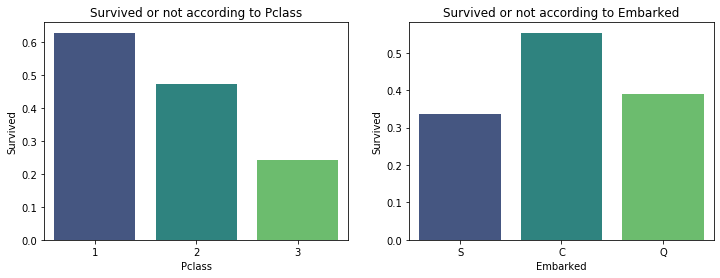

In [7]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

sns.barplot(ax=axes[0], x='Pclass', y='Survived', data=data, ci=False, palette='viridis')
axes[0].set_title('Survived or not according to Pclass')

sns.barplot(ax=axes[1], x='Embarked', y='Survived', data=data, ci=False, palette='viridis')
axes[1].set_title('Survived or not according to Embarked')

##### Thoughts
Clearly, first class was the safest, as we all know, firstly titanic crew helped "rich guests" to escape. They offered them boats and life vests. <br>
But what abot Embarkerd? As we can see, Cherbourg(C) was the safest port, but what the reason why? I do not whant to dive deeper, let's assume that from Cherbourg were more reach passengers.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [8]:
data_missing = pd.DataFrame({'Percentage of missing values' : data.isna().mean(axis=0)})
data_missing.style.format('{:.2%}')

,Percentage of missing values
Survived,0.00%
Pclass,0.00%
Name,0.00%
Sex,0.00%
Age,19.87%
SibSp,0.00%
Parch,0.00%
Ticket,0.00%
Fare,0.00%
Cabin,77.10%


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

##### Thoughts
First thing first, Cabin feature may be dropped as it is highly incomplete or contains many null values .
Second thing second, Embarked feature has only 2 missing values, it is a categorical variable, that is why null values may be filled with mode value. 
Third thing third, Age feature has 20% of missing values, it is going to be a good idea to fill null values with median, as median age is the same for sirvived and deaceased passengers.

#### P.S. It were my thoughts before modeling, and i were completely mistaken
Only one thing if you want to get a higher score, you have to do feature engeneering. That's what i might do in futher steps.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [9]:
y = data['Survived']

In [10]:
test = pd.read_csv('test.csv', index_col='PassengerId')

In [11]:
df = pd.concat([data.drop(columns='Survived'), test])

In [12]:
df.isna().mean(axis=0)

Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.200917
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000764
Cabin       0.774637
Embarked    0.001528
dtype: float64

### Extracting the passenger titles
If we take a look at passangers names, we will see that they has Titles. The titles are correlate with age, because every title corresponde to social status or other. For instance, Miss is unmarried woman, master is a male child, Mr is a grown man. The title will help us to fill NaN values in column Age.

In [13]:
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [14]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

After some time in the internet, i have known that we can split titles in the next groups:

In [15]:
titles = {
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Jonkheer': 'Royalty',
    'Don': 'Royalty',
    'Dona': 'Royalty',
    'Sir' : 'Royalty',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'Countess':'Royalty',
    'Mme': 'Mrs',
    'Mlle': 'Miss',
    'Ms': 'Mrs',
    'Mr' : 'Mr',
    'Mrs' : 'Mrs',
    'Miss' : 'Miss',
    'Master' : 'Master',
    'Lady' : 'Royalty'
}

Let's replace all the titles into corresponded groups.

In [16]:
df['Title'].replace(titles, inplace=True)
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'], dtype=object)

### Fill NaNs in Age Column
Now, when we have a Titles, it is going to be more correctly to fill NaNs with corresponding age in title group, then with median. But not only according Title, but Pclass aswell. Let's do it.

In [17]:
# Create a DF with corresponding Age to title and class
ages = df.groupby(['Pclass', 'Title'], as_index=False).mean()[['Pclass', 'Title', 'Age']]
# Create additional column for replacing
ages['Pclass+Title'] = ages['Pclass'].astype(str) + ages['Title']
# Create dictionary 
dict_ages = dict(zip(ages['Pclass+Title'], ages['Age']))
dict_ages

{'1Master': 6.984,
 '1Miss': 30.131147540983605,
 '1Mr': 41.45075757575758,
 '1Mrs': 42.9264705882353,
 '1Officer': 50.916666666666664,
 '1Royalty': 41.166666666666664,
 '2Master': 2.7572727272727273,
 '2Miss': 20.71708333333333,
 '2Mr': 32.346715328467155,
 '2Mrs': 33.41818181818182,
 '2Officer': 40.7,
 '3Master': 6.090000000000001,
 '3Miss': 17.36087378640777,
 '3Mr': 28.318910256410255,
 '3Mrs': 32.326530612244895}

In [18]:
# Replacing NaN values to median age in class according to tile
df['Age'] = df['Age'].fillna(df['Pclass'].astype(str) + df['Title']).replace(dict_ages)

###  Fill NaN values in Fare column
As Fare has only 1 NaN value and it belongs to person from third class, it's obvious to replace NaN value with corresponding mode value.

In [19]:
df[df['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr


In [20]:
mode_fare3 = df[df['Pclass'] == 3]['Fare'].mode()[0]
df['Fare'].fillna(mode_fare3, inplace=True)

###  Fill NaN values in Embarked column
Let's fill NaNs with most frequent Embarked value for passangers from first class.

In [21]:
df[df['Embarked'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


In [22]:
df['Embarked'].fillna(df[df['Pclass'] == 1]['Embarked'].mode(), inplace=True)

### Cabin Feature
Let's take a look, does deck matters or not (letter in Cabin feature)?
Firstly, let's extrack deck from column Cabin.

In [23]:
df['Deck'] = df['Cabin'].str.extract('([A-Z]+)', expand=False)

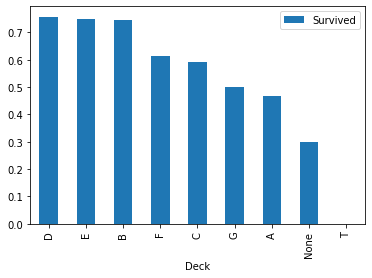

In [24]:
data['Deck'] = df.iloc[data.index,]['Deck']
data.fillna({'Deck': 'None'}).groupby('Deck', as_index=True).mean()[['Survived']].sort_values(by='Survived',\
                                                                                              ascending=False).plot(kind='bar')

How i assuemed before, Deck metters. Lets replace None deck values with 'None'

In [25]:
df['Deck'].fillna('None', inplace=True)

But what about tickets, maybe letters in tickets metters too? Lets dive deeper.

### Exploaring Ticket feature

In [26]:
df['Ticket_type'] = df['Ticket'].astype(str).map(lambda x: re.sub('[/.]', '', x)).str.extract('([A-Z]+)', expand=False)

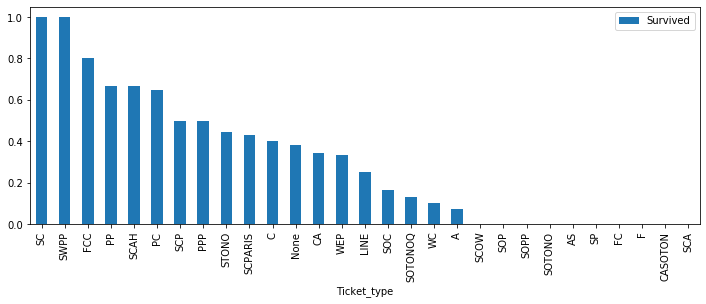

In [27]:
data['Ticket_type'] = df.iloc[data.index,]['Ticket_type']
data.fillna({'Ticket_type': 'None'}).groupby('Ticket_type', as_index=True)\
.mean()[['Survived']].sort_values(by='Survived', ascending=False).plot(kind='bar', figsize=(12,4))

Type of tickets metters too. Let's fill NaN values with 'None' and continue investigation.

In [28]:
df['Ticket_type'].fillna('None', inplace=True)

### And the last for now, Family feature. Is it easier to survive with big family or when you alone?

In [29]:
# calculate family size
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

Text(0, 0.5, 'Survived')

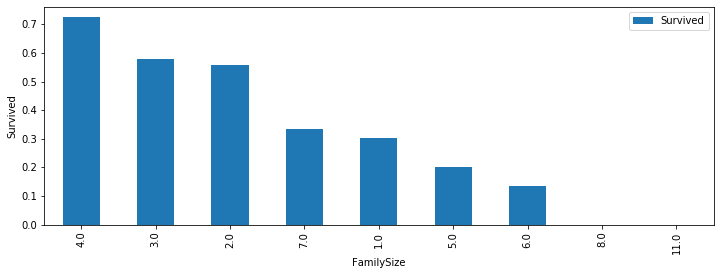

In [30]:
# plot the results
data['FamilySize'] = df.iloc[data.index,]['FamilySize']

data.groupby('FamilySize', as_index=True)\
.mean()[['Survived']]\
.sort_values(by='Survived', ascending=False)\
.plot(kind='bar', figsize=(12,4))

plt.ylabel('Survived')


Interesting results. That mens, the medium size families had a higher survival rate then others. And the large families and passangers who were alone had less survival ratio.
Let's split this feature in 3 different features: Is_alone, SmallFamily, LargeFamily.

In [31]:
# introducing other features based on the family size
df['Is_alone'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

### Label encoding
The dataftame has plenty of categorical features and we have to deal with it. One way is to encode it binary features.

In [32]:
features_to_encode = ['Pclass', 'Sex', 'Title', 'Embarked', 'Deck', 'Ticket_type']
df = pd.get_dummies(df, columns=features_to_encode)

##### This is the endpoint of feature engeneering. Next step is modeling.

# Modeling
We will use Logistick Regression and K-NN algorith for the classification.
For startpoint, let's select features for modeling and get started

In [33]:
cols_modeling = ['Age', 'Fare', 'Is_alone', 'SmallFamily', 'LargeFamily', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_None', 'Deck_T',
       'Ticket_type_A', 'Ticket_type_AQ', 'Ticket_type_AS', 'Ticket_type_C',
       'Ticket_type_CA', 'Ticket_type_CASOTON', 'Ticket_type_F',
       'Ticket_type_FC', 'Ticket_type_FCC', 'Ticket_type_LINE',
       'Ticket_type_LP', 'Ticket_type_None', 'Ticket_type_PC',
       'Ticket_type_PP', 'Ticket_type_PPP', 'Ticket_type_SC',
       'Ticket_type_SCA', 'Ticket_type_SCAH', 'Ticket_type_SCOW',
       'Ticket_type_SCP', 'Ticket_type_SCPARIS', 'Ticket_type_SOC',
       'Ticket_type_SOP', 'Ticket_type_SOPP', 'Ticket_type_SOTONO',
       'Ticket_type_SOTONOQ', 'Ticket_type_SP', 'Ticket_type_STONO',
       'Ticket_type_STONOQ', 'Ticket_type_SWPP', 'Ticket_type_WC',
       'Ticket_type_WEP']

##### Recreate test and train dataframe 

In [34]:
df_train = df.iloc[:data.shape[0],][cols_modeling]
df_test = df.iloc[data.shape[0]:][cols_modeling]

##### Select models for modeling

In [35]:
models = [LogisticRegression(solver='liblinear'), KNeighborsClassifier(n_neighbors=5)]

##### Let's test our models with cross validation
End of exercise: <i>(1.5 points) Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!<i>

In [36]:
for model in models:
    print(cross_validate(model, df_train, y, cv=5)['test_score'].mean())

0.8305316678174629
0.7149582574854059


##### Not so bad, but lets do  feature selection to prevent overfitting. 
Remarkably, KNN didn't do well with this task. Some reason of it that data is not scaled. Knn on scaled gave better results, but best score on kaggle i get with Logreg.<br>
In this case, i might choose  `SelectFromModel` with `RandomForestClassifier(n_estimators=50, max_features='sqrt')`.
Lets try and see what we get

In [37]:
# model for feature selection
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt') 
clf = clf.fit(df_train, y)
model = SelectFromModel(clf, prefit=True)

# result of feature selection
df_train_reduced = model.transform(df_train)
df_test_reduced = model.transform(df_test)
print ('reduced shape ', df_train_reduced.shape)

reduced shape  (891, 12)


##### Now let's see the importance of each feature according to `SelectFromModel`

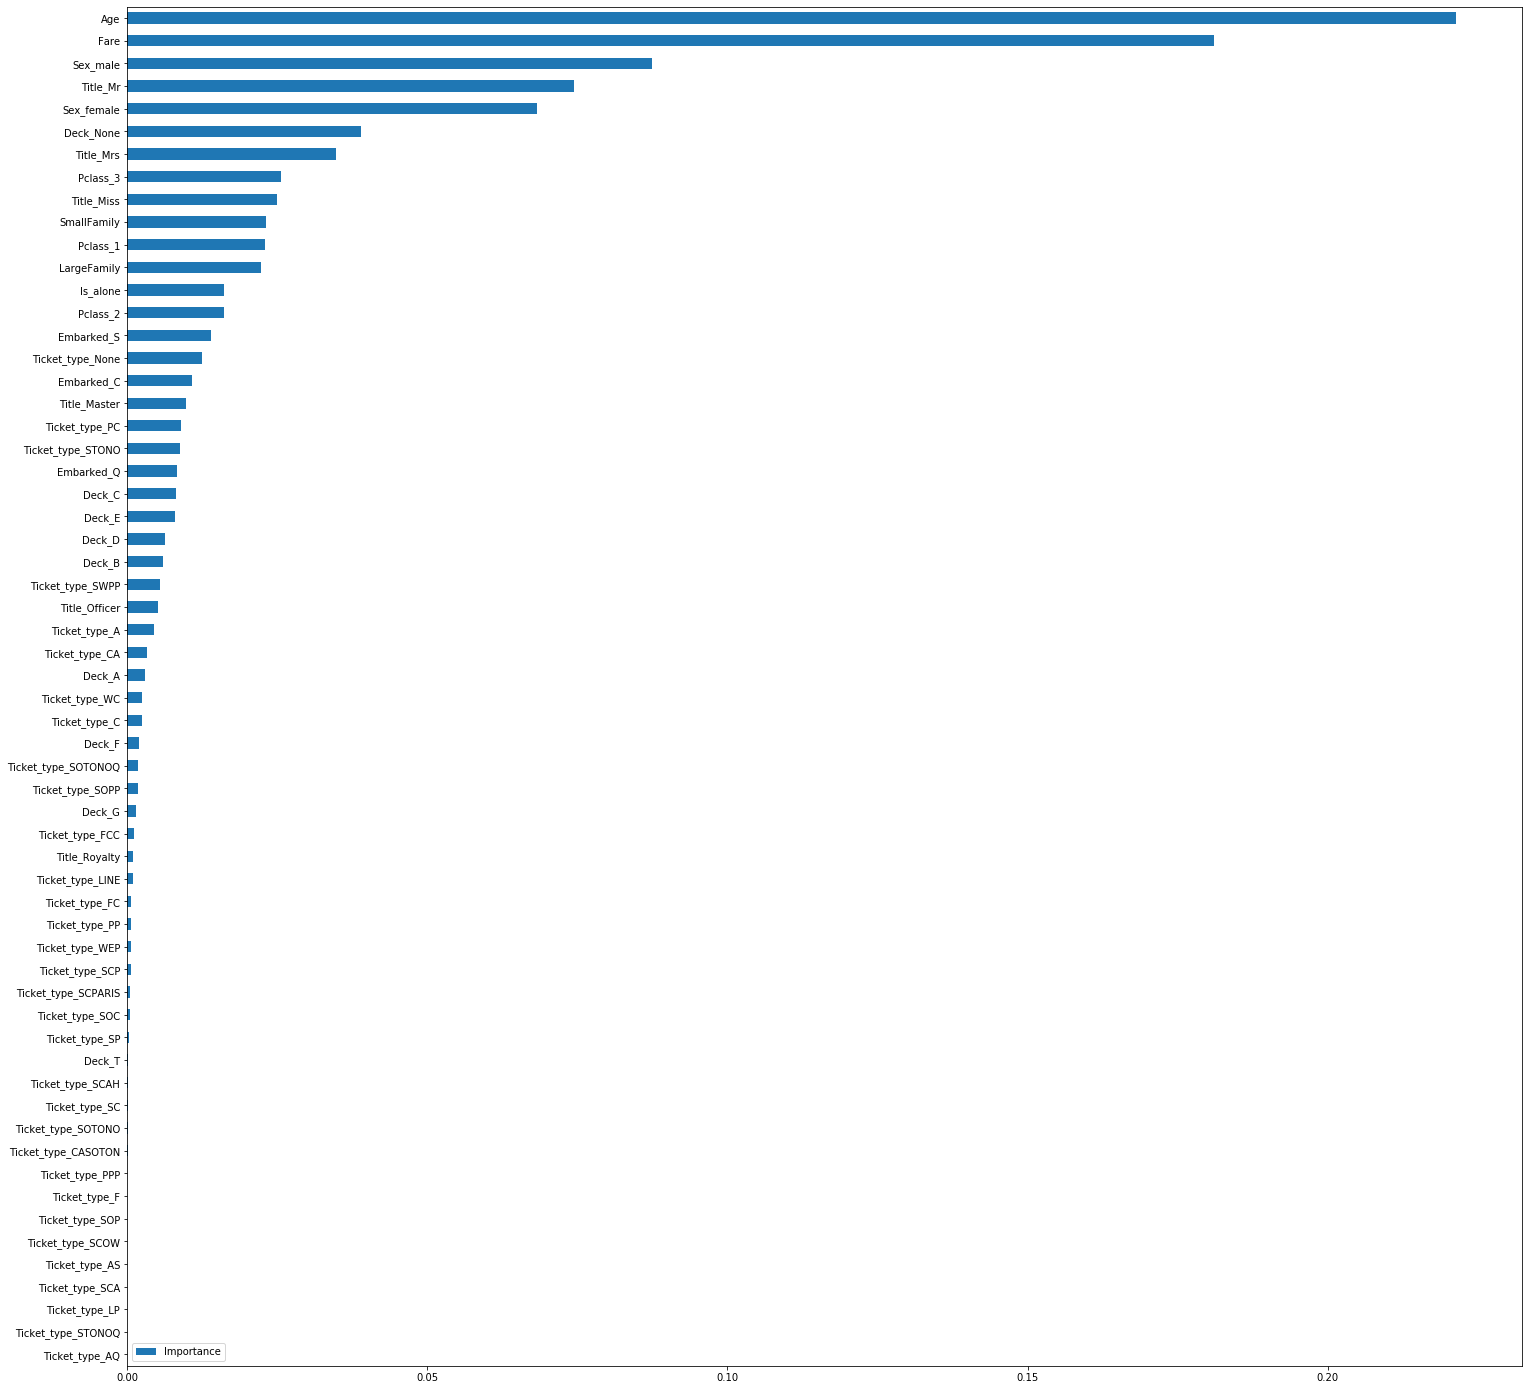

In [38]:
feature_importance = pd.DataFrame(index=df_train.columns, data={'Importance' : clf.feature_importances_})\

feature_importance.sort_values(by='Importance').plot(kind='barh', figsize=(25,25))

In [39]:
# check how they accurate with reduced features
for model in models:
    print(cross_validate(model, df_train_reduced, y, cv=5)['test_score'].mean())

0.8181783943255289
0.7026300922729269


##### Accuracy became a little bit less, but less features can make out model more stable and prevent from overfitting.
Let's make predictions and check the Kaggle score. I will use only Logistick Regression because it's more stable on unscaled data and i get the best result on Kaggle with it.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_train_reduced, y, test_size=0.3, random_state=46)
models[0].fit(X_train, y_train)
print(accuracy_score(y_test, models[0].predict(X_test)))

result = models[0].predict(df_test_reduced)


0.8507462686567164


In [41]:
to_kaggle = pd.DataFrame({'PassengerId': test.index, 'Survived' : result})
to_kaggle.to_csv('log_random.csv', index=False)

# Results

#### 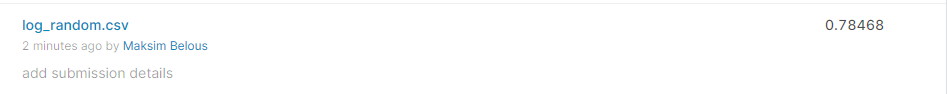

##### [My Kaggle account](https://www.kaggle.com/maksimbelous)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

## Additional point is 1!
it was hard